In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyslim, tskit
import itertools
import scipy.special
import os, subprocess, sys
from Bio import Phylo
from io import StringIO
import msprime
import tqdm
from pathlib import Path
import statsmodels.stats.proportion
import glob
import joblib

sys.path.append(str(Path(os.getcwd()).parent))

In [3]:
from src import extract_tree_stats, curve_inference

# Test for a single tree

In [299]:
ts = tskit.load("/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/neutral_desai_20230626/seed=47/output.trees")

In [300]:
sts = ts.simplify([ts.individual(i).nodes[0] for i in pyslim.individuals_alive_at(ts, 0)])

In [301]:
n_lineages = extract_tree_stats.get_lineages(sts, 4000, [0], [10000])

In [302]:
mutation_times = []
mutation_edges = []
for m in sts.mutations():
    if len(m.metadata["mutation_list"]):
        mutation_times.append(m.time)
        mutation_edges.append(m.edge)

In [318]:
m

Mutation(id=6344, site=6324, node=431, derived_state='3197309', parent=-1, metadata={'mutation_list': [{'mutation_type': 1, 'selection_coeff': 0.0, 'subpopulation': 1, 'slim_time': 4000, 'nucleotide': -1}]}, time=0.0, edge=2326)

In [303]:
n_bins = 100
hist_bins = np.linspace(0, 4000, n_bins+1, endpoint=True)
mut_counts_per_bin = np.histogram(mutation_times, bins=hist_bins)[0]

In [194]:
n_lineages_per_bin = n_lineages.reshape((n_bins, -1)).sum(axis=1)

In [195]:
mutation_rate_est = mut_counts_per_bin / n_lineages_per_bin
mutation_rate_low_ci, mutation_rate_high_ci = \
    statsmodels.stats.proportion.proportion_confint(mut_counts_per_bin, n_lineages_per_bin, method="beta")

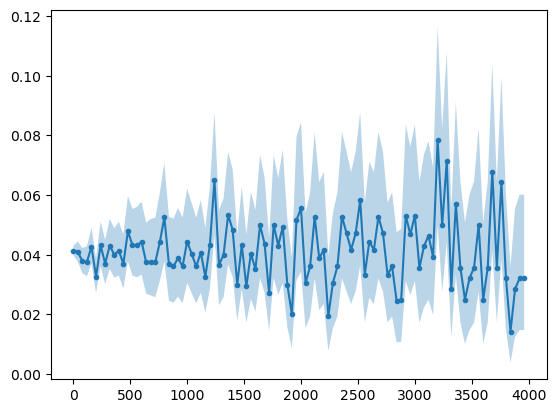

In [196]:
plt.plot(hist_bins[:-1], mutation_rate_est, '.-');
plt.fill_between(hist_bins[:-1], mutation_rate_low_ci, mutation_rate_high_ci, alpha=0.3, label='Confidence Band')


# Across many trees

In [156]:
def get_mutation_counts_and_lineages_for_ts(
    filename, 
    max_generations, 
    sample_times, 
    sample_sizes,
    n_bins
):
    # Load file
    ts = tskit.load(filename)
    
    # Remove the empty second chromosomes and their associates useless mutations
    sts = ts.simplify(np.arange(0, len(ts.nodes_time), 2))
    
    # Take subset of samples
    sts = sts.simplify([sts.individual(i).nodes[0] for sample_time in sample_times for i in pyslim.individuals_alive_at(sts, sample_time)])
    
    mutation_times = []
    mutation_weights = []
    for variant in sts.variants():
        for mutation in variant.site.mutations:
            mutation_times.append(mutation.time)
            mutation_weights.append(sts.num_samples - variant.counts()[''])
    
    hist_bins = np.linspace(0, max_generations, n_bins+1, endpoint=True)
    mut_counts_per_bin = np.histogram(mutation_times, bins=hist_bins, weights=mutation_weights)[0]

    n_lineages = np.zeros(max_generations, dtype=int)
    for sample_time, sample_size in zip(sample_times, sample_sizes):
        n_lineages[sample_time:] += sample_size
    n_lineages_per_bin = n_lineages.reshape((n_bins, -1)).sum(axis=1)
    
    return mut_counts_per_bin, n_lineages_per_bin
    

In [118]:
filenames = glob.glob("/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/neutral_desai_20230626/seed=*/output.trees")

n_bins = 100
max_generations = 4000
hist_bins = np.linspace(0, max_generations, n_bins+1, endpoint=True)
all_res = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(get_mutation_counts_and_lineages_for_ts)(filename, max_generations, [0], [10000], n_bins) \
           for filename in filenames
)
# all_res = [get_mutation_counts_and_lineages_for_ts(filename, max_generations, [0], [10000], n_bins) \
#             for filename in filenames]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 76 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of 100 | elapsed:   41.6s remaining: 16.6min
[Parallel(n_jobs=-1)]: Done  15 out of 100 | elapsed:   42.7s remaining:  4.0min
[Parallel(n_jobs=-1)]: Done  26 out of 100 | elapsed:   43.0s remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  37 out of 100 | elapsed:   44.2s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  48 out of 100 | elapsed:   44.6s remaining:   48.3s
[Parallel(n_jobs=-1)]: Done  59 out of 100 | elapsed:   45.2s remaining:   31.4s
[Parallel(n_jobs=-1)]: Done  70 out of 100 | elapsed:   45.3s remaining:   19.4s
[Parallel(n_jobs=-1)]: Done  81 out of 100 | elapsed:   45.4s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  92 out of 100 | elapsed:   46.5s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.5s finished


In [119]:
mut_counts_per_bin, n_lineages_per_bin = np.array(all_res).sum(axis=0)

mutation_rate_est = mut_counts_per_bin / n_lineages_per_bin
mutation_rate_low_ci, mutation_rate_high_ci = \
    statsmodels.stats.proportion.proportion_confint(mut_counts_per_bin, n_lineages_per_bin, method="beta")

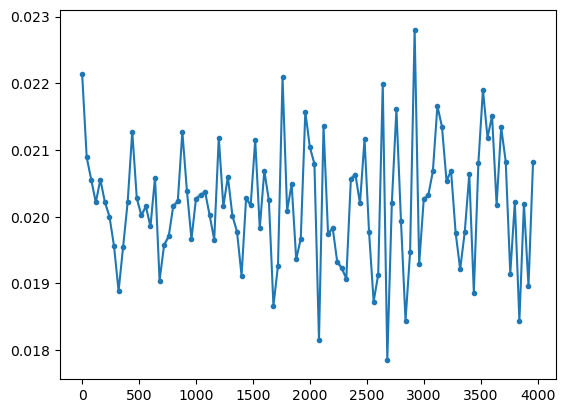

In [120]:
plt.plot(hist_bins[:-1], mutation_rate_est, '.-');
plt.fill_between(hist_bins[:-1], mutation_rate_low_ci, mutation_rate_high_ci, alpha=0.3, label='Confidence Band')
#plt.axhline(0.04, ls='--', lw=1, color="black")

# Now try non-neutral

In [125]:
filenames = glob.glob("/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/another_desai_20230626/seed=*/output.trees")
    
n_bins = 4000
max_generations = 4000
hist_bins = np.linspace(0, max_generations, n_bins+1, endpoint=True)
all_res = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(get_mutation_counts_and_lineages_for_ts)(filename, max_generations, [0], [10000], n_bins) \
           for filename in filenames
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 76 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of 100 | elapsed:    0.7s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done  15 out of 100 | elapsed:    1.0s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  26 out of 100 | elapsed:    1.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  37 out of 100 | elapsed:    1.2s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  48 out of 100 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  59 out of 100 | elapsed:    1.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  70 out of 100 | elapsed:    2.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  81 out of 100 | elapsed:    2.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  92 out of 100 | elapsed:    2.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished


In [126]:
mut_counts_per_bin, n_lineages_per_bin = np.array(all_res).sum(axis=0)

mutation_rate_est = mut_counts_per_bin / n_lineages_per_bin
mutation_rate_low_ci, mutation_rate_high_ci = \
    statsmodels.stats.proportion.proportion_confint(mut_counts_per_bin, n_lineages_per_bin, method="beta")

In [127]:
def effective_mutation_rate_theory(t, Ud, s):
    return Ud * np.exp(-s * t)

In [128]:
biancas_ts = np.array("1 21 41 61 81 101 121 141 161 181 201 221 241 261 281 301 321 341 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701 721 741 761 781 801 821 841 861 881 901 921 941 961 981 1001 1021 1041 1061 1081 1101 1121 1141 1161 1181 1201 1221 1241 1261 1281 1301 1321 1341 1361 1381 1401 1421 1441 1461 1481 1501 1521 1541 1561 1581 1601 1621 1641 1661 1681 1701 1721 1741 1761 1781 1801 1821 1841 1861 1881 1901 1921 1941 1961 1981".split()).astype(int)-1
biancas = np.array("0.01977339 0.01593422 0.01243647 0.009999399 0.007672448 0.006205632 0.004959085 0.003443733 0.00218873 0.001490243 0.001180687 0.0008905787 0.0007291442 0.0006021037 0.0004929608 0.0003489779 0.0002574171 0.0002107553 0.0001725518 0.0001029764 8.430998e-05 6.902717e-05 5.651467e-05 4.62703e-05 3.788292e-05 3.101591e-05 2.539368e-05 2.079059e-05 1.702189e-05 1.393635e-05 1.141012e-05 9.341812e-06 7.648429e-06 6.262004e-06 5.126895e-06 4.197547e-06 1.815728e-06 1.486592e-06 1.217119e-06 1.547501e-08 1.266986e-08 1.10749e-08 9.06736e-09 7.423726e-09 6.078033e-09 4.976273e-09 4.074227e-09 1.013721e-09 6.648793e-11 5.443571e-11 0.01919182 0.01559359 0.0126866 0.009914477 0.007695782 0.005819256 0.004557227 0.003281517 0.002454219 0.001721099 0.001027379 0.0008087835 0.0006662816 0.0004193005 0.0002757802 0.0002372742 0.0001942637 0.0001590497 0.0001302188 0.0001024579 8.388545e-05 6.86796e-05 5.62301e-05 4.603731e-05 2.369514e-05 1.939994e-05 4.214546e-06 3.450578e-06 2.640355e-06 2.16174e-06 1.769883e-06 1.449058e-06 1.186388e-06 9.713324e-07 7.952597e-07 1.168638e-07 9.568001e-08 7.833617e-08 4.446898e-08 3.640812e-08 2.980845e-08 3.050637e-08 2.49765e-08 2.044903e-08 1.674225e-08 1.370739e-08 1.122266e-08 1.225112e-08 1.003036e-08 8.212168e-09".split()).astype(float)

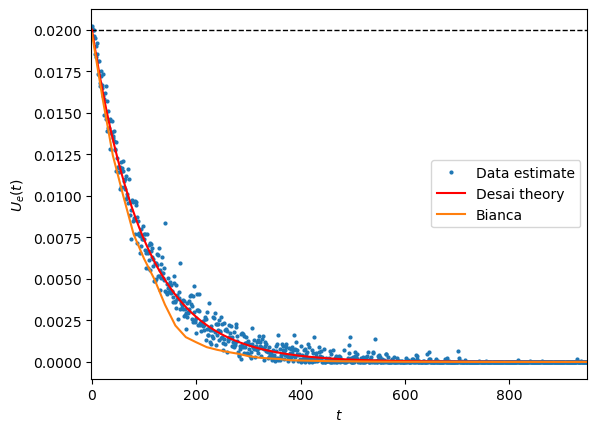

In [140]:
times = hist_bins[:-1]
plt.plot(times, mutation_rate_est, '.', ms=4, label="Data estimate");
#plt.fill_between(times, mutation_rate_low_ci, mutation_rate_high_ci, alpha=0.3, label='Confidence Band')
plt.axhline(0.02, ls='--', lw=1, color="black")
plt.plot(times, effective_mutation_rate_theory(times, 0.02, 0.01), color="red", label="Desai theory")
plt.plot(biancas_ts, biancas, label="Bianca")
plt.xlim(-1,1000-50)
plt.xlabel("$t$")
plt.ylabel(r"$U_e(t)$")
plt.legend()

# Now non-neutral with two times

In [157]:
filenames = glob.glob("/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/two_times_1000_20230706/seed=*/output.trees")
    
n_bins = 2000
max_generations = 2000
hist_bins = np.linspace(0, max_generations, n_bins+1, endpoint=True)
all_res = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(get_mutation_counts_and_lineages_for_ts)(filename, max_generations, [0, 1000], [10000, 10000], n_bins) \
           for filename in filenames
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 76 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of 100 | elapsed:    6.9s remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  15 out of 100 | elapsed:    6.9s remaining:   39.3s
[Parallel(n_jobs=-1)]: Done  26 out of 100 | elapsed:    7.0s remaining:   19.8s
[Parallel(n_jobs=-1)]: Done  37 out of 100 | elapsed:    7.0s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  48 out of 100 | elapsed:    7.0s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  59 out of 100 | elapsed:    7.0s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  70 out of 100 | elapsed:    7.1s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  81 out of 100 | elapsed:    7.4s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  92 out of 100 | elapsed:    7.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.4s finished


In [158]:
mut_counts_per_bin, n_lineages_per_bin = np.array(all_res).sum(axis=0)

mutation_rate_est = mut_counts_per_bin / n_lineages_per_bin

In [159]:
def effective_mutation_rate_theory(t, Ud, s):
    return Ud * np.exp(-s * t)

In [162]:
#biancas_ts = np.array("1 21 41 61 81 101 121 141 161 181 201 221 241 261 281 301 321 341 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701 721 741 761 781 801 821 841 861 881 901 921 941 961 981 1001 1021 1041 1061 1081 1101 1121 1141 1161 1181 1201 1221 1241 1261 1281 1301 1321 1341 1361 1381 1401 1421 1441 1461 1481 1501 1521 1541 1561 1581 1601 1621 1641 1661 1681 1701 1721 1741 1761 1781 1801 1821 1841 1861 1881 1901 1921 1941 1961 1981".split()).astype(int)-1
biancas = np.array("0.01980008 0.01960306 0.01938034 0.01913038 0.01894003 0.01875157 0.01853545 0.01835102 0.0181382 0.01795772 0.01774811 0.01750759 0.01730036 0.01709443 0.01688978 0.01672172 0.01654126 0.01637667 0.01617775 0.01601678 0.01585741 0.01569963 0.01552802 0.01537351 0.01518306 0.01503198 0.01480469 0.01459846 0.0144532 0.01424841 0.01406277 0.01392284 0.01378431 0.01364715 0.01351136 0.01333198 0.01315322 0.01297503 0.01284593 0.01269309 0.01251729 0.01236791 0.01224485 0.01207781 0.01191589 0.0117412 0.01160907 0.01152931 0.01138331 0.01127004 0.01109748 0.01098706 0.01087774 0.01077975 0.01067982 0.01050292 0.01039842 0.01029495 0.0100875 0.009987125 0.009887752 0.009718506 0.009589241 0.009529908 0.009422599 0.009281138 0.009048771 0.008958734 0.008869593 0.008731619 0.008608179 0.0084895 0.008405029 0.008264021 0.008079423 0.007999032 0.00791944 0.00784064 0.007764051 0.007696453 0.007495072 0.007354816 0.007281635 0.007261721 0.007189466 0.007076519 0.007006107 0.006936395 0.006911633 0.006900258 0.006819957 0.006808849 0.0067411 0.0066139 0.006615731 0.006463905 0.006399588 0.006335911 0.006200368 0.006138673 0.006077592 0.006017119 0.005957248 0.005897972 0.005839286 0.005781185 0.005723661 0.00566671 0.005610325 0.005554501 0.005499233 0.005444515 0.005390341 0.005336706 0.005283605 0.005231032 0.005178983 0.005127451 0.005076432 0.00502592 0.004975912 0.004926401 0.004877382 0.004828851 0.004680708 0.004634134 0.004469961 0.004276711 0.004234157 0.004192027 0.004037228 0.003997057 0.003957286 0.00391791 0.003878926 0.00384033 0.003802118 0.003764287 0.003726831 0.003689749 0.003653035 0.003616687 0.0035807 0.003545072 0.003509798 0.003474875 0.003440299 0.003406068 0.003372177 0.003338623 0.003305403 0.003076482 0.002985202 0.002955498 0.002926091 0.002896976 0.00286815 0.002839612 0.002811357 0.002783384 0.002755688 0.002728269 0.002701122 0.002674246 0.002647636 0.002621292 0.002507617 0.002482666 0.002457963 0.002300308 0.00227742 0.002254759 0.002232324 0.002063528 0.002042996 0.001801933 0.001784004 0.001766253 0.001748678 0.001731279 0.001714052 0.001696997 0.001680112 0.001663394 0.001646843 0.001630457 0.001614234 0.001598172 0.00158227 0.001566526 0.001550939 0.001535506 0.001520228 0.001505101 0.001490125 0.001360949 0.001347407 0.001374999 0.001361317 0.001347772 0.001334361 0.001187877 0.001176058 0.001164356 0.00115277 0.0011413 0.001129944 0.001118701 0.001107569 0.001096549 0.001085638 0.001074836 0.001064141 0.001053552 0.001043069 0.001032691 0.001022415 0.001012242 0.00100217 0.0009921983 0.0009823258 0.0009725515 0.0009628745 0.0008860453 0.000877229 0.0008685005 0.000496439 0.0004914993 0.0004866088 0.000481767 0.0004769733 0.0004722274 0.0004675286 0.0004628766 0.0004582709 0.0004537111 0.0004491966 0.000444727 0.0004403019 0.0004775415 0.0004727899 0.0004680855 0.000463428 0.0004588168 0.0004542515 0.0004497317 0.0004452567 0.0004408264 0.0004416809 0.0005465022 0.0005410644 0.0005356807 0.0005303506 0.0005250736 0.000519849 0.0005146764 0.0005095553 0.0005044851 0.0004994654 0.0004944957 0.0004895753 0.000484704 0.0004798811 0.0004751062 0.0004703788 0.0004656985 0.0004610647 0.000456477 0.000451935 0.0004474382 0.0004429861 0.0004385783 0.0004342144 0.0004298939 0.0004256164 0.0004213814 0.0004171886 0.0004130375 0.0004089277 0.0004048588 0.0004008304 0.0003968421 0.0003928934 0.0003889841 0.0003851136 0.0003812817 0.0003774878 0.0003737318 0.0003700131 0.0003663314 0.0003626863 0.0003590775 0.0003555047 0.0003519673 0.0003484652 0.0003449979 0.0003451031 0.0003416693 0.0003382696 0.0003349038 0.0003315714 0.0003282723 0.0003250059 0.000321772 0.0003185703 0.0003154005 0.0003122622 0.0003091552 0.000306079 0.0003030335 0.0003000182 0.000297033 0.0002940775 0.0002911514 0.0002882544 0.0002853862 0.0002825465 0.0002797352 0.0002769518 0.000274196 0.0002714677 0.0002687666 0.0002660923 0.0002634447 0.0002608233 0.0002582281 0.0002556587 0.0002531148 0.0002505963 0.0002481028 0.0002456342 0.0003615115 0.0003579144 0.0003543531 0.0003508272 0.0003473364 0.0003438804 0.0003404587 0.0003370711 0.0003337172 0.0003303966 0.0003271091 0.0003238543 0.0003206319 0.0003174416 0.000314283 0.0003111558 0.0003080598 0.0003049945 0.0003019598 0.0002989552 0.0002959806 0.0002930355 0.0002901198 0.000287233 0.000284375 0.0002815454 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 0.01980106 0.01960404 0.01940897 0.01921585 0.01902465 0.01883535 0.01864794 0.018433 0.01824959 0.01803798 0.01782785 0.01765046 0.01744353 0.01726996 0.01709812 0.01689599 0.01669518 0.01652906 0.0163646 0.01620177 0.01604056 0.01588095 0.01572293 0.01556649 0.01537812 0.0152251 0.01503938 0.01481901 0.01463501 0.01448939 0.01430785 0.01416548 0.01396828 0.01382929 0.01366926 0.01353325 0.01339859 0.01324738 0.01311557 0.01298506 0.01281425 0.01270492 0.01260671 0.0124616 0.01233761 0.01221484 0.01204889 0.011929 0.01181031 0.01160055 0.01146127 0.01134723 0.01123432 0.01107371 0.01094071 0.01078075 0.010621 0.01051532 0.01040963 0.01025063 0.01014864 0.009990725 0.009891316 0.009792895 0.009637031 0.009462335 0.009304997 0.00921241 0.009055756 0.008965649 0.008773052 0.008649412 0.008563349 0.008433084 0.008336142 0.008218958 0.008031453 0.007951538 0.007872419 0.007794087 0.007716535 0.007639754 0.007563737 0.007488477 0.007413965 0.007340195 0.007297549 0.007224937 0.007153048 0.007000946 0.006902545 0.006833864 0.00678139 0.006693742 0.006658257 0.006630142 0.006461003 0.006396715 0.006376462 0.006313015 0.006141499 0.005904521 0.00584577 0.005787603 0.005730016 0.005587084 0.00540208 0.00530995 0.005257115 0.005204806 0.005012742 0.004962865 0.00484848 0.004800237 0.004685081 0.004607943 0.00476796 0.004769065 0.004735572 0.004665055 0.004479845 0.004319997 0.004190791 0.004149092 0.004107808 0.003845529 0.003807265 0.003769382 0.003731876 0.003694744 0.00365798 0.003621583 0.003585547 0.003549871 0.003514549 0.003479578 0.003444956 0.003377952 0.003344341 0.003311064 0.003278118 0.0032455 0.003213207 0.003181235 0.003149581 0.003118243 0.00282414 0.00279604 0.002602783 0.002576885 0.002551245 0.002305983 0.001938219 0.00191535 0.001521317 0.001703555 0.001706893 0.001689909 0.002059722 0.002039228 0.002018937 0.001332557 0.001319298 0.00130617 0.001293174 0.001280307 0.001267567 0.001254955 0.001242468 0.001230105 0.001217865 0.001205747 0.00119375 0.001181872 0.001170112 0.001158469 0.001146942 0.00113553 0.001124231 0.001113045 0.00110197 0.001091005 0.00108015 0.001069402 0.001058761 0.001048226 0.001037796 0.00102747 0.001017247 0.001007125 0.0009971037 0.0009871824 0.0009773598 0.0009676349 0.0009580067 0.0009484744 0.0009390369 0.0009296934 0.0009204428 0.0009112842 0.0009022168 0.0008932396 0.0008843517 0.0008755522 0.001300227 0.001287289 0.00127448 0.001261799 0.001249244 0.001236814 0.001224507 0.001212323 0.00120026 0.001188318 0.001176494 0.001164787 0.001153198 0.001141723 0.001130363 0.001119115 0.00110798 0.001096955 0.001086041 0.001075234 0.001064536 0.001053943 0.001043456 0.001033074 0.001022795 0.001012618 0.001002542 0.0009925664 0.0009826902 0.0009729122 0.0009632316 0.0009536473 0.0009441583 0.0009347638 0.0009254627 0.0009162542 0.0009071374 0.0008981112 0.0008891748 0.0008803274 0.000871568".split()).astype(float)

In [164]:
biancas_ts = np.arange(len(biancas))
biancas[biancas < 0] = np.nan

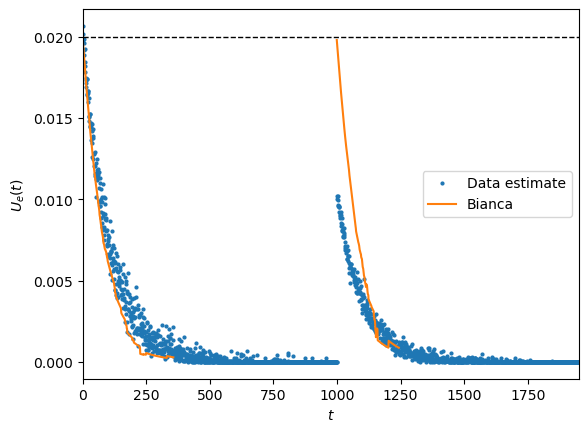

In [165]:
times = hist_bins[:-1]
plt.plot(times, mutation_rate_est, '.', ms=4, label="Data estimate");
plt.axhline(0.02, ls='--', lw=1, color="black")
#plt.plot(times, effective_mutation_rate_theory(times, 0.02, 0.01), color="red", label="Desai theory")
plt.plot(biancas_ts, biancas, label="Bianca")
plt.xlim(-1,2000-50)
plt.xlabel("$t$")
plt.ylabel(r"$U_e(t)$")
plt.legend()

# Simple estimators

## Only Ud and s, no dated tips, ages known

In [4]:
filenames = glob.glob("/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/another_desai_20230626/seed=*/output.trees")



In [5]:
ts = tskit.load(filenames[0])
sts = ts.simplify(np.arange(0, len(ts.nodes_time), 2))
sts = sts.simplify([sts.individual(i).nodes[0] for sample_time in [0] for i in pyslim.individuals_alive_at(sts, sample_time)])
mts = msprime.sim_mutations(
       sts,
       rate=0/sts.sequence_length,    # per bp
       model=msprime.SLiMMutationModel(type=3, next_id=pyslim.next_slim_mutation_id(sts)), # type=3 is just any mutation type unused in the simulation
       keep=True,
)

In [7]:
mut_times, mut_weights = \
    np.array([(variant.site.mutations[0].time,  sts.num_samples - variant.counts()['']) for variant in mts.variants()]).T

In [36]:
def log_likelihood(x, sequence_length, n_samples, mut_times, mut_weights):
    Ud, s = x
    p = Ud/(s*sequence_length)
    
    LL = scipy.stats.poisson.logpmf(k=1, mu=p) *  mut_weights.sum()
    LL += scipy.stats.poisson.logpmf(k=0, mu=p) * (sequence_length * n_samples - mut_weights.sum())
    LL += (scipy.stats.geom.logpmf(k=mut_times+1, p=s) * mut_weights).sum()
    
    return LL
    

In [39]:
res = scipy.optimize.minimize(
    fun=lambda *args: -1*log_likelihood(*args),
    x0=(0.5, 0.5),
    args=(mts.sequence_length, mts.num_samples, mut_times, mut_weights),
    method="Nelder-Mead",
    bounds=[(1e-10,1-1e-10), (1e-10,1)],
)

print(res)
print(res.x)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 406067.68082908995
             x: [ 1.876e-02  9.141e-03]
           nit: 69
          nfev: 137
 final_simplex: (array([[ 1.876e-02,  9.141e-03],
                       [ 1.876e-02,  9.142e-03],
                       [ 1.876e-02,  9.141e-03]]), array([ 4.061e+05,  4.061e+05,  4.061e+05]))
[0.01875941 0.00914111]
